### V2LOL
##### cleanin up da data

In [7]:
#IMPORT BOX 9000

import numpy as np #the ogs
import pandas as pd
import matplotlib.pyplot as plt
import os
import requests


from sklearn.preprocessing import LabelEncoder

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn as nn
from torchvision.models import resnet50
import torch.optim as optim

from tqdm import tqdm

##### LOADING AND MERGING DATA

In [8]:
# Load datasets
train_df = pd.read_csv(r"google-landmark\train.csv")
hierarchical_df = pd.read_csv(r"google-landmark\train_label_to_hierarchical.csv")
# Merge datasets
merged_df = pd.merge(train_df, hierarchical_df, on="landmark_id", how="inner")

# Filter relevant columns
merged_df = merged_df[["id", "url", "landmark_id", "category", "hierarchical_label","natural_or_human_made"]]
merged_df = merged_df.dropna(subset=["hierarchical_label", "natural_or_human_made"])
# Save merged data
merged_df.to_csv("merged_train.csv", index=False)



##### PREPPING & CLEANING DATA FOR BETTER FILTERED DATASET
(new to v2)

hierarchical_label
church           452652
parks            243759
castle / fort    228373
museum           177508
mountain         156490
                  ...  
pyramid            1229
artwork            1076
swimming pool       984
cross               716
stairs              675
Name: count, Length: 78, dtype: int64


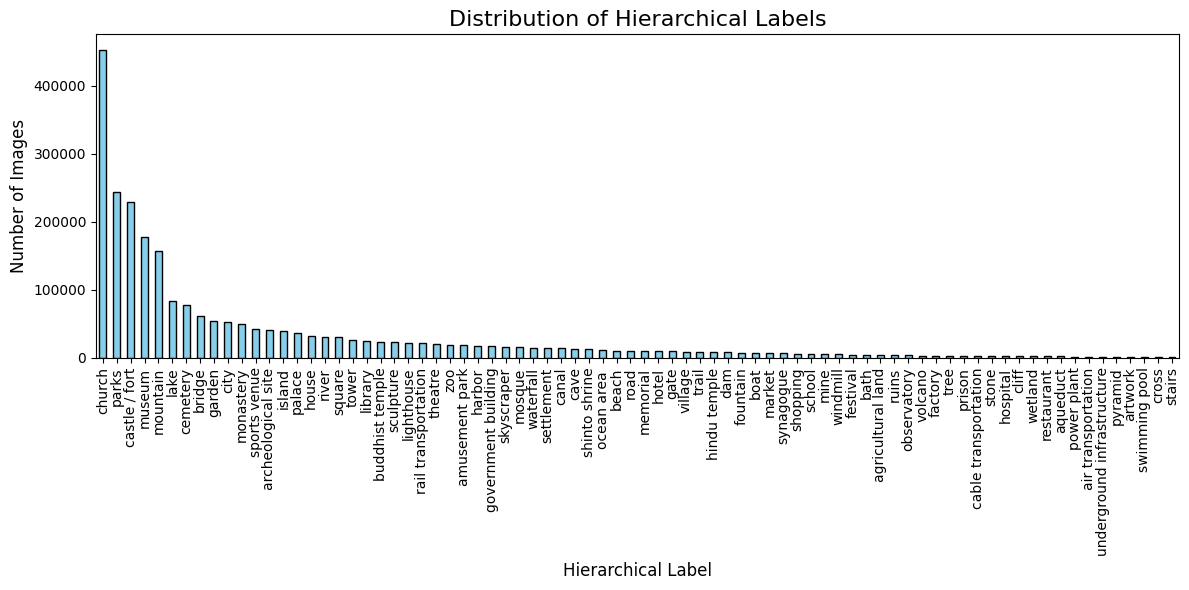

In [9]:
#info about the csvs we use
# print(f"Duplicates in train.csv: {train_df.duplicated().sum()}")
# print(f"Duplicates in train_label_to_hierarchical.csv: {hierarchical_df.duplicated().sum()}")
# print(f"Number of rows after merge: {len(merged_df)}")

hierarchy_counts = merged_df["hierarchical_label"].value_counts()

# Plot the histogram
plt.figure(figsize=(12, 6))
hierarchy_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.title("Distribution of Hierarchical Labels", fontsize=16)
plt.xlabel("Hierarchical Label", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()


print(merged_df["hierarchical_label"].value_counts())
# Show the plot
plt.show()


The distribution here is kinda seriously skewed towards churches - with smaller landmarks like stairs with very few points, thus never being trained properly if left like this.

This next code cell will attempt to remedy this with our subsampling of the dataset, making sure all of the points are represented, while attempting to maintain a fair representation of the more prevalent entries, with a hyper-parameter to help weigh them

hierarchical_label
church                763
parks                 486
castle / fort         466
museum                399
mountain              371
                     ... 
artwork               165
air transportation    165
power plant           165
cross                 164
stairs                164
Name: Balanced Counts, Length: 78, dtype: int64


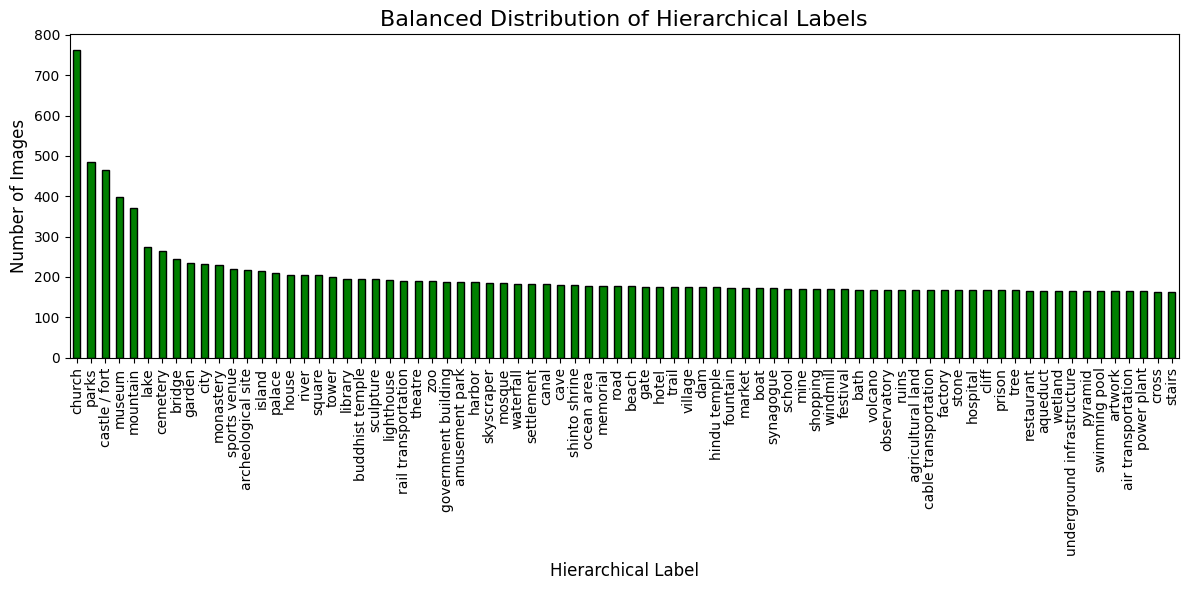

In [10]:
# Define adjustable weighting: a mix of proportional and equal distribution
equal_weight = 0.8  # Adjust between 0 (completely proportional) and 1 (completely uniform)
total_rows = 16000  # Total desired rows

# Calculate equal and proportional shares
equal_share = total_rows // len(hierarchy_counts)
proportional_share = hierarchy_counts / hierarchy_counts.sum() * total_rows

# Combine the two shares
target_counts = (equal_weight * equal_share + (1 - equal_weight) * proportional_share).astype(int)

# Map each label to its target count
label_to_target_count = dict(zip(hierarchy_counts.index, target_counts))

# Sample data based on the calculated target counts
balanced_sample = merged_df.groupby("hierarchical_label", group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), label_to_target_count.get(x.name, 0)), random_state=42)
)

# Save the new dataset
balanced_sample.to_csv("balanced_train_v2.csv", index=False)

# Display the final stats
balanced_stats = balanced_sample["hierarchical_label"].value_counts()
balanced_stats.name = "Balanced Counts"
print(balanced_stats)

# Plot the new distribution
plt.figure(figsize=(12, 6))
balanced_stats.sort_values(ascending=False).plot(kind='bar', color='green', edgecolor='black')

# Add labels and title
plt.title("Balanced Distribution of Hierarchical Labels", fontsize=16)
plt.xlabel("Hierarchical Label", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()


This works much better, with the lesser categories still holding at a minimum 21 data points, giving them representation.

In [11]:
import aiohttp #excluded from the import box 9000 as they are cool
import asyncio
from tqdm.asyncio import tqdm
import nest_asyncio

# Apply the patch for nested event loops
nest_asyncio.apply()

# Load CSV
filtered_df = pd.read_csv("balanced_train_v2.csv")

# # Create a directory to store images
# output_dir = "filtered_images2"
# os.makedirs(output_dir, exist_ok=True)

# # Define headers to mimic a browser
# headers = {
#     "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
# }

# # Global list for failed downloads
# failed_downloads = []

# # Define an async function to download a single image with retries
# async def download_image(session, row, output_dir, max_retries=3):
#     image_id = row['id']
#     url = row['url']
#     output_path = os.path.join(output_dir, f"{image_id}.jpg")
    
#     for attempt in range(max_retries):
#         try:
#             await asyncio.sleep(0.5)  # Add a short delay between requests
#             async with session.get(url, headers=headers, timeout=10) as response:
#                 if response.status == 200:
#                     with open(output_path, "wb") as f:
#                         f.write(await response.read())
#                     return f"Downloaded {image_id}"
#                 else:
#                     return f"Failed to download {image_id}: {response.status}"
#         except Exception as e:
#             if attempt < max_retries - 1:
#                 await asyncio.sleep(2 + attempt)  # Exponential backoff
#                 continue
#             failed_downloads.append({"id": image_id, "url": url})
#             return f"Error downloading {image_id} after {max_retries} attempts: {e}"


# # Define the main async function with progress tracking
# async def process_batch(session, batch, output_dir):
#     tasks = [
#         download_image(session, row, output_dir)
#         for _, row in batch.iterrows()
#     ]
#     for result in tqdm(asyncio.as_completed(tasks), total=len(tasks)):
#         message = await result
#         print(message)

# async def download_images_with_progress(filtered_df, output_dir, batch_size=1000):
#     connector = aiohttp.TCPConnector(limit_per_host=10)
#     async with aiohttp.ClientSession(connector=connector) as session:
#         num_batches = (len(filtered_df) + batch_size - 1) // batch_size
#         for i in range(num_batches):
#             batch = filtered_df.iloc[i * batch_size:(i + 1) * batch_size]
#             await process_batch(session, batch, output_dir)


# async def download_image_with_timeout(session, row, output_dir, max_retries=3, timeout=15):
#     try:
#         return await asyncio.wait_for(
#             download_image(session, row, output_dir, max_retries), timeout
#         )
#     except asyncio.TimeoutError:
#         image_id = row['id']
#         url = row['url']
#         failed_downloads.append({"id": image_id, "url": url})
#         return f"Timeout for {image_id}"

# async def retry_failed_downloads(output_dir, retries=2):
#     for attempt in range(retries):
#         if not failed_downloads:
#             break
#         to_retry = failed_downloads.copy()
#         failed_downloads.clear()
#         await download_images_with_progress(pd.DataFrame(to_retry), output_dir, batch_size=500)

# if __name__ == "__main__":
#     # Start the event loop
#     asyncio.run(download_images_with_progress(filtered_df, output_dir, batch_size=1000))

#     # Retry failed downloads if there are any
#     if failed_downloads:
#         print("\nRetrying failed downloads...")
#         asyncio.run(retry_failed_downloads(output_dir, retries=2))

#     # Save failed downloads for inspection
#     if failed_downloads:
#         pd.DataFrame(failed_downloads).to_csv("failed_downloads.csv", index=False)
#         print("\nFailed downloads saved to 'failed_downloads.csv'.")
#     else:
#         print("\nAll images downloaded successfully!")


In [12]:
#images that failed to download get removed by this line
image_dir = r"filtered_images2"
existing_images = set(os.listdir(image_dir))

filtered_df = filtered_df[filtered_df["id"].apply(lambda x: f"{x}.jpg").isin(existing_images)]


#encoding both hierarchical && natural/manmade labels
label_encoder_hierarchical = LabelEncoder()
label_encoder_natural = LabelEncoder()

filtered_df["hierarchical_label_encoded"] = label_encoder_hierarchical.fit_transform(filtered_df["hierarchical_label"])
filtered_df["natural_or_human_made_encoded"] = label_encoder_natural.fit_transform(filtered_df["natural_or_human_made"])

#saving to another csv :fire emoji:
filtered_df.to_csv("multi_task_trainv2.csv", index=False)

#info about labels for checking
print(f"Number of hierarchical labels: {filtered_df['hierarchical_label_encoded'].nunique()}")
print(f"Number of natural/human-made categories: {filtered_df['natural_or_human_made_encoded'].nunique()}")
print(f"Dataset size: {len(filtered_df)}")


Number of hierarchical labels: 78
Number of natural/human-made categories: 2
Dataset size: 15710


In [13]:
#Creating a class to associate the image with a tensor tuple (the categories we're training on)

class LandmarkDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = csv_file.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get image metadata from the CSV
        row = self.data.iloc[idx]
        image_id = row['id']
        label_hierarchical = row['hierarchical_label_encoded']
        label_natural = row['natural_or_human_made_encoded']

        label_hierarchical = torch.tensor(label_hierarchical, dtype=torch.long)
        label_natural = torch.tensor(label_natural, dtype=torch.long)

        # Load the image
        image_path = os.path.join(self.image_dir, f"{image_id}.jpg")
        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return None  # Return None if image loading fails

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Return image and both labels as a tuple
        return image, (label_hierarchical, label_natural)




In [14]:
#Define preprocessing transformations
#preprocessing converts the images to tensors for machine learning.
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

In [15]:
#The model itself :2 fire emojis:

# Define device based on availability of CUDA (for NVIDIA GPUs) or fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet50 model
model = resnet50(pretrained=True)

# Create two separate heads for the tasks
num_hierarchical_labels = filtered_df["hierarchical_label_encoded"].nunique()
num_natural_labels = filtered_df["natural_or_human_made_encoded"].nunique()

# Replace the original fully connected layer
model.fc = nn.Identity()  # Remove the existing fully connected layer

class MultiTaskModel(nn.Module):
    def __init__(self, base_model, num_hierarchical_labels, num_natural_labels):
        super(MultiTaskModel, self).__init__()
        
        # Use the base model without the last fully connected layer
        self.base = nn.Sequential(*list(base_model.children())[:-1])
        
        # Output features from the penultimate layer
        in_features = base_model.fc.in_features
        
        # Two separate heads for multi-task learning
        self.head_hierarchical = nn.Linear(in_features, num_hierarchical_labels)
        self.head_natural = nn.Linear(in_features, num_natural_labels)

    def forward(self, x):
        # Extract features using the base model
        features = self.base(x)
        features = features.view(features.size(0), -1)  # Flatten for linear layers

        # Output predictions for both tasks
        hierarchical_out = self.head_hierarchical(features)
        natural_out = self.head_natural(features)
        return hierarchical_out, natural_out

# Example: Adjust the model for two tasks
from torchvision.models import resnet50

# Load pre-trained ResNet50
base_model = resnet50(pretrained=True)

hierarchical_encoder = LabelEncoder()
filtered_df["hierarchical_label_encoded"] = hierarchical_encoder.fit_transform(filtered_df["hierarchical_label"])

# Encode natural_or_human_made
natural_encoder = LabelEncoder()
filtered_df["natural_or_human_made_encoded"] = natural_encoder.fit_transform(filtered_df["natural_or_human_made"])

# Save the encoded classes for reference
num_hierarchical_labels = len(hierarchical_encoder.classes_)
num_natural_labels = len(natural_encoder.classes_)

# Initialize the multi-task model
multi_task_model = MultiTaskModel(base_model, num_hierarchical_labels, num_natural_labels)


# Move the model to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
multi_task_model = multi_task_model.to(device)

# Print model summary
print(multi_task_model)

c:\Users\adamj\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\adamj\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MultiTaskModel(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(

In [16]:
#the training code

def train_model(model, train_loader, val_loader, optimizer, num_epochs=10):
    criterion_hierarchical = nn.CrossEntropyLoss()
    criterion_natural = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_hierarchical, correct_natural = 0, 0
        total = 0

        for batch in tqdm(train_loader):
            if batch is None:
                continue  # Skip empty batches
            images, (labels_hierarchical, labels_natural) = batch

            images = images.to(device)
            labels_hierarchical = labels_hierarchical.to(device)
            labels_natural = labels_natural.to(device)

            # Forward pass
            optimizer.zero_grad()
            out_hierarchical, out_natural = model(images)

            # Compute losses
            loss_hierarchical = criterion_hierarchical(out_hierarchical, labels_hierarchical)
            loss_natural = criterion_natural(out_natural, labels_natural)
            loss = loss_hierarchical + loss_natural  # Combine losses

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Update metrics
            running_loss += loss.item()
            _, predicted_hierarchical = torch.max(out_hierarchical, 1)
            _, predicted_natural = torch.max(out_natural, 1)
            total += labels_hierarchical.size(0)
            correct_hierarchical += (predicted_hierarchical == labels_hierarchical).sum().item()
            correct_natural += (predicted_natural == labels_natural).sum().item()

        accuracy_hierarchical = correct_hierarchical / total
        accuracy_natural = correct_natural / total

        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {running_loss / len(train_loader):.4f}")
        print(f"Hierarchical Accuracy: {accuracy_hierarchical:.4f}")
        print(f"Natural/Human-made Accuracy: {accuracy_natural:.4f}")
        


# Initialize model, optimizer, and loaders
num_hierarchical_labels = filtered_df['hierarchical_label'].nunique()
num_natural_labels = filtered_df['natural_or_human_made'].nunique()

multi_task_model = MultiTaskModel(base_model, num_hierarchical_labels, num_natural_labels)
multi_task_model = multi_task_model.to(device)

# Define optimizer
optimizer = optim.Adam(multi_task_model.parameters(), lr=0.001)

In [17]:
from torch.utils.data.dataloader import default_collate

def collate_fn(batch):
    # Filter out None samples
    batch = list(filter(lambda x: x is not None, batch))
    if len(batch) == 0:
        return None  # Skip this batch
    return default_collate(batch)

#initializing the dataset, and doing the machine learning
dataset = LandmarkDataset(csv_file=filtered_df, image_dir=image_dir, transform=transform)

# Split the dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])


print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")

train_loader = DataLoader(train_data, batch_size=64, shuffle=True,collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False,collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False,collate_fn=collate_fn)

print(f"Train data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(test_data)}\n")

#chunk of code to show extra data regarding shapes (if curious)
for images, (labels_hierarchical, labels_natural) in train_loader:
    print(f"Images batch shape: {images.shape}")
    print(f"Hierarchical labels batch: {labels_hierarchical}")
    print(f"Natural labels batch: {labels_natural}")
    break

print(device)

Train size: 10997, Val size: 3142, Test size: 1571
Train data size: 10997
Validation data size: 3142
Test data size: 1571

Images batch shape: torch.Size([64, 3, 224, 224])
Hierarchical labels batch: tensor([26, 77, 47, 46,  5, 30,  8, 19,  6, 30, 74, 26,  1, 46,  3, 74, 49, 72,
        46, 26, 46, 72, 58, 51, 75,  5, 17, 24,  3, 73, 23, 61, 76, 34, 42,  1,
        37, 63, 37, 64, 61, 55, 56, 49, 51, 72, 76, 54, 12, 22, 69,  1, 13, 73,
        71, 69, 69, 45, 31, 52,  1, 11, 16, 13])
Natural labels batch: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0])
cuda


In [18]:
#the ol' ball and chain (long process)
train_model(multi_task_model, train_loader, val_loader, optimizer, num_epochs=20)

 58%|█████▊    | 99/172 [08:39<06:17,  5.17s/it]c:\Users\adamj\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\JpegImagePlugin.py:880: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
 78%|███████▊  | 135/172 [11:43<03:01,  4.91s/it]

Error loading image filtered_images2\fd2c8cbdd494d183.jpg: broken data stream when reading image file


 91%|█████████ | 156/172 [13:36<01:19,  4.98s/it]c:\Users\adamj\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 172/172 [14:54<00:00,  5.20s/it]


Epoch 1/20
Train Loss: 4.6157
Hierarchical Accuracy: 0.0627
Natural/Human-made Accuracy: 0.7835


 26%|██▌       | 45/172 [03:44<10:32,  4.98s/it]


KeyboardInterrupt: 

In [ ]:
torch.save(multi_task_model, "LOLV2MODEL.pth")
# Load the entire model
# multi_task_model = torch.load("LOLV2.pth")

# # Set the model to evaluation mode
# multi_task_model.eval()
# print("Entire model loaded successfully")

In [ ]:
#the ol' test tickle

def test_model(model, test_loader):
    """
    Test the multi-task model on the test dataset.
    
    Args:
        model (nn.Module): Trained multi-task model.
        test_loader (DataLoader): DataLoader for the test dataset.
    """
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track performance
    correct_hierarchical, correct_natural = 0, 0
    total = 0

    # Disable gradient computation for testing
    with torch.no_grad():
        for images, (labels_hierarchical, labels_natural) in tqdm(test_loader):
            # Move data to the same device as the model
            images = images.to(device)
            labels_hierarchical = labels_hierarchical.to(device)
            labels_natural = labels_natural.to(device)

            # Forward pass
            outputs_hierarchical, outputs_natural = model(images)

            # Get predictions
            _, predicted_hierarchical = torch.max(outputs_hierarchical, 1)
            _, predicted_natural = torch.max(outputs_natural, 1)

            # Update counts
            total += labels_hierarchical.size(0)
            correct_hierarchical += (predicted_hierarchical == labels_hierarchical).sum().item()
            correct_natural += (predicted_natural == labels_natural).sum().item()

    # Calculate accuracy for both tasks
    hierarchical_accuracy = 100.0 * correct_hierarchical / total
    natural_accuracy = 100.0 * correct_natural / total

    # Print results
    print(f"Test Results:")
    print(f"Hierarchical Label Accuracy: {hierarchical_accuracy:.2f}%")
    print(f"Natural vs. Human-Made Accuracy: {natural_accuracy:.2f}%")

# Run the test
test_model(multi_task_model, test_loader)